## 0. Clean data

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

Data cleaning: This data analysis problem is a regression problem on price prediction. Firstly, we have to clean the target-price, and secondly, we have to clean the variables used to predict the target, including numerical variables as well as categorical variables. The target-price is a text variable in the csv file, so it needs to be processed for text, and we also need to remove some extreme values from the price to avoid them affecting the accuracy of the model. For the prediction variables, we observe that each price has a timestamp, so we can decompose the timestamp variables into year, quater, month and weekday, while the other category variables can be replaced by 0-1 if there are only two categories, or 0ne-hot if there are three or more. Finally we removed variables that were not relevant to the prediction target and features with a high number of missing values.  
By cleaning the data we can get more useful features, reduce the influence of noise in the data and ultimately improve the accuracy of the model.

In [3]:
df = pd.read_csv('ppr-21201409.csv')
df['Date of Sale (dd/mm/yyyy)'] = pd.to_datetime(df['Date of Sale (dd/mm/yyyy)'], dayfirst=True, format='%d/%m/%Y')
df = df.rename(columns={'Date of Sale (dd/mm/yyyy)': 'Date of Sale'})
for idx, row in df.iterrows():
    df.loc[idx, ['Price (€)']] = float(row['Price (€)'][1:].replace(',',''))
df['Price (€)'] = df['Price (€)'].astype('float')
df = df.rename(columns={'Price (€)': 'Price'})
df.head()

,Date of Sale,Address,Postal Code,County,Price,Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description
0,2016-01-20,"44 ABBOTOWN AVE, FINGLAS WEST, DUBLIN 11",Dublin 11,Dublin,165000.0,No,No,Second-Hand Dwelling house /Apartment,NaN
1,2018-03-09,"29 SHANDON COURT, UPPER YELLOW RD, WATERFORD",NaN,Waterford,110000.0,No,No,Second-Hand Dwelling house /Apartment,NaN
2,2020-03-24,"8 THE NURSERIES, TANEY ROAD, DUNDRUM",Dublin 14,Dublin,733149.0,No,Yes,New Dwelling house /Apartment,NaN
3,2014-07-25,"12 St. Davids Wood, Artane",Dublin 5,Dublin,380000.0,No,No,Second-Hand Dwelling house /Apartment,NaN
4,2017-12-21,"178 THE FAYTHE, WEXFORD, CO WEXFORD",NaN,Wexford,100000.0,No,No,Second-Hand Dwelling house /Apartment,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date of Sale               10000 non-null  datetime64[ns]
 1   Address                    10000 non-null  object        
 2   Postal Code                1910 non-null   object        
 3   County                     10000 non-null  object        
 4   Price                      10000 non-null  float64       
 5   Not Full Market Price      10000 non-null  object        
 6   VAT Exclusive              10000 non-null  object        
 7   Description of Property    10000 non-null  object        
 8   Property Size Description  1028 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(7)
memory usage: 703.2+ KB


### process target: price

In [5]:
''' Detection '''
# IQR
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1
print("Old Shape: ", df.shape)
test_4 = df[((df['Price'] < Q1 - 1.5 * IQR) | (df['Price'] > Q3 + 1.5 * IQR))]
# ''' Removing the Outliers '''
df.drop(test_4.index, inplace=True)
print("New Shape: ", df.shape)

Old Shape:  (10000, 9)
New Shape:  (9430, 9)


### process Date of Sale

In [6]:
test_3 = []
for i in range(df.shape[0]):
    if df.iloc[i]['Date of Sale'] > np.datetime64('2022-01-24T00:00:00Z'):
        test_3.append(df.iloc[i])
test_3 = pd.DataFrame(test_3)
print("Old Shape: ", df.shape)
# Check for cases that are later than 24 January 2022
print("Total number of rows dropped: ", test_3.shape[0])
df = df.drop(test_3.index)
print("New Shape: ", df.shape)

Old Shape:  (9430, 9)
Total number of rows dropped:  0
New Shape:  (9430, 9)


### process Address

In [7]:
# drop column 'Address' because the entropy value is too large to give valid information
df = df.drop(['Address'], axis=1)

### process Postal Code

In [8]:
df["Postal Code"].value_counts()

Dublin 15       260
Dublin 24       113
Dublin 9        103
Dublin 8        102
Dublin 18       102
Dublin 13        95
Dublin 11        94
Dublin 7         92
Dublin 16        79
Dublin 12        72
Dublin 4         70
Dublin 5         69
Dublin 3         69
Dublin 14        63
Dublin 22        56
Dublin 1         52
Dublin 6         46
Dublin 2         32
Dublin 10        28
Dublin 17        22
Dublin 20        18
Dublin 6w        10
Ní Bhaineann      1
Name: Postal Code, dtype: int64

In [9]:
df = df.drop(['Postal Code'], axis=1) # too many empty values, so remove it.

### process County

In [10]:
df["County"].value_counts()

Dublin       2754
Cork         1082
Kildare       508
Galway        500
Meath         366
Limerick      361
Wexford       321
Kerry         285
Waterford     282
Wicklow       282
Tipperary     278
Donegal       258
Louth         246
Clare         228
Mayo          222
Westmeath     199
Sligo         158
Laois         156
Cavan         149
Roscommon     146
Kilkenny      140
Offaly        131
Carlow        124
Monaghan       96
Longford       81
Leitrim        77
Name: County, dtype: int64

### process Not Full Market Price

In [11]:
df["Not Full Market Price"].value_counts()

No     8958
Yes     472
Name: Not Full Market Price, dtype: int64

### process VAT Exclusive 

In [12]:
df["VAT Exclusive"].value_counts()

No     7919
Yes    1511
Name: VAT Exclusive, dtype: int64

### process Description of Property

In [13]:
df["Description of Property"].value_counts()

Second-Hand Dwelling house /Apartment    7894
New Dwelling house /Apartment            1534
Teach/Árasán Cónaithe Atháimhe              2
Name: Description of Property, dtype: int64

In [14]:
df = df.drop(df[df['Description of Property']=='Teach/Árasán Cónaithe Atháimhe'].index) # remove outliers

### process Property Size Description

In [15]:
df["Property Size Description"].value_counts()

greater than or equal to 38 sq metres and less than 125 sq metres    723
greater than 125 sq metres                                           106
greater than or equal to 125 sq metres                                91
less than 38 sq metres                                                61
Name: Property Size Description, dtype: int64

In [16]:
df = df.drop(['Property Size Description'], axis=1) # too many empty values, so remove it.

### overall 

In [17]:
df.describe(include="all")

,Date of Sale,County,Price,Not Full Market Price,VAT Exclusive,Description of Property
count,9428,9428,9428.000000,9428,9428,9428
unique,2740,26,NaN,2,2,2
top,2016-12-22 00:00:00,Dublin,NaN,No,No,Second-Hand Dwelling house /Apartment
freq,20,2754,NaN,8956,7917,7894
first,2010-01-04 00:00:00,NaN,NaN,NaN,NaN,NaN
last,2022-01-11 00:00:00,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,209633.797767,NaN,NaN,NaN
std,NaN,NaN,123015.418371,NaN,NaN,NaN
min,NaN,NaN,5963.000000,NaN,NaN,NaN
25%,NaN,NaN,113000.000000,NaN,NaN,NaN


## 1.Data Understanding and Preparation

### 1.1 

In [18]:
from sklearn.model_selection import train_test_split
# split data to two datasets: 70% training and 30% test
train_data, test_data = train_test_split(df, test_size=0.3, shuffle=True, random_state=0) 

In [19]:
train_data.head()

,Date of Sale,County,Price,Not Full Market Price,VAT Exclusive,Description of Property
3695,2018-04-30,Donegal,120000.0,No,No,Second-Hand Dwelling house /Apartment
2163,2016-12-02,Dublin,115000.0,Yes,No,Second-Hand Dwelling house /Apartment
7509,2021-01-08,Galway,520555.0,No,No,Second-Hand Dwelling house /Apartment
3199,2012-02-24,Meath,60000.0,No,No,Second-Hand Dwelling house /Apartment
9324,2016-01-20,Tipperary,165000.0,Yes,No,Second-Hand Dwelling house /Apartment


In [20]:
print("train data shape:", train_data.shape)
print("test data shape:", test_data.shape)

train data shape: (6599, 6)
test data shape: (2829, 6)


### 1.2 

In [21]:
df1 = train_data.copy() # get a copy of original df
df1["month"] = df1["Date of Sale"].dt.month # get month feature from Date of sale
df1["quarter"] = df1["Date of Sale"].dt.quarter # get quarter feature from Date of sale
df1["weekday"] = df1["Date of Sale"].dt.weekday # get weekday feature form Date of sale
df1.head()

,Date of Sale,County,Price,Not Full Market Price,VAT Exclusive,Description of Property,month,quarter,weekday
3695,2018-04-30,Donegal,120000.0,No,No,Second-Hand Dwelling house /Apartment,4,2,0
2163,2016-12-02,Dublin,115000.0,Yes,No,Second-Hand Dwelling house /Apartment,12,4,4
7509,2021-01-08,Galway,520555.0,No,No,Second-Hand Dwelling house /Apartment,1,1,4
3199,2012-02-24,Meath,60000.0,No,No,Second-Hand Dwelling house /Apartment,2,1,4
9324,2016-01-20,Tipperary,165000.0,Yes,No,Second-Hand Dwelling house /Apartment,1,1,2


Because the three continuous variables month, quarter and weekday are extracted from Date of sale, there is no need to plot the correlations between all the continuous features

Text(0.5,1,'Price~weekday')

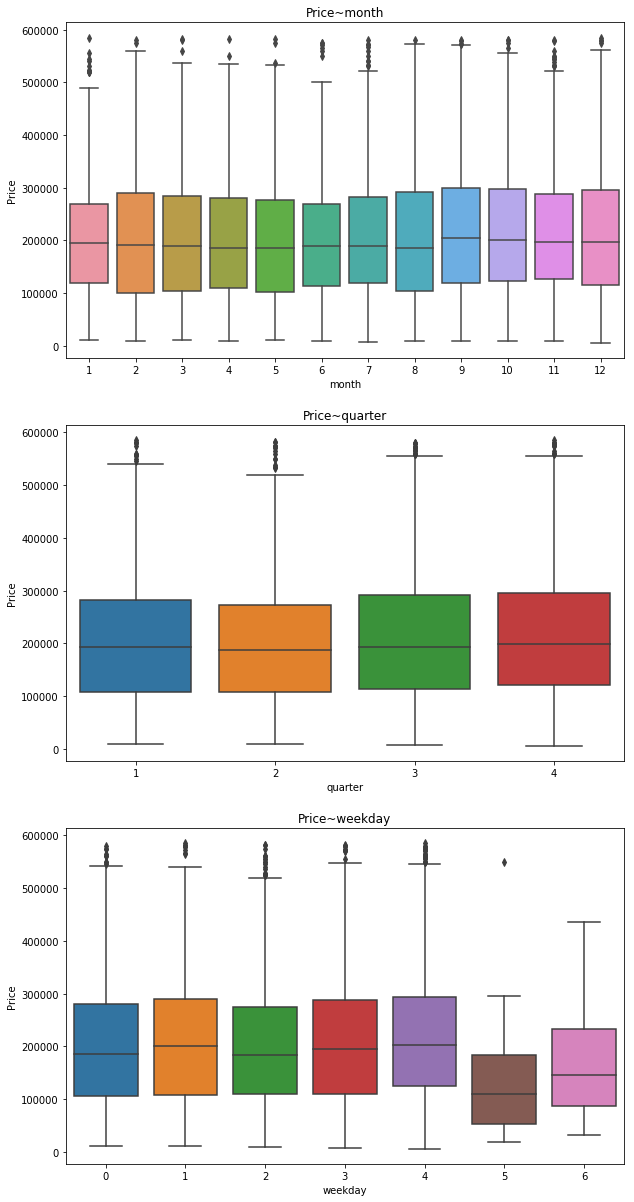

In [22]:
### pair boxplot of continuous feature and target feature

plt.figure(figsize=(10, 21))
plt.subplot(3, 1, 1)
sns.boxplot(x="month", y="Price", data=df1)
plt.title("Price~month")
plt.subplot(3, 1, 2)
sns.boxplot(x="quarter", y="Price", data=df1)
plt.title("Price~quarter")
plt.subplot(3, 1, 3)
sns.boxplot(x="weekday", y="Price", data=df1)
plt.title("Price~weekday")

  We extracted three new variables from Date of Sale, month, quater and weekday, which can be considered as continuous variables, and made box plots for price and these three variables respectively. From the first graph price~month, we can see that the median and minimum values of price in each month are almost equal, the maximum values are different, and there are more outliers above the maximum values. The distance between the 25% quantile and the 75% quantile in June is the smallest, indicating that price is more concentrated in June, while the distance between the 25% quantile and the 75% quantile in December is the largest, indicating that price is more dispersed in December.  
  The second graph, price~quarter, shows that the median price for each quarter, the minimum value is almost equal and the maximum value is not very different, and the 25% and 75% quartiles of price for each quarter are also almost the same, indicating that this feature of quater does not have a significant impact on price, as we will discard this feature in the subsequent analysis.  
  In the third graph, price~weekday, you can see that the median price varies significantly by weekday, with Friday's price being significantly smaller, including the 25% quantile and the 75% quantile. There is also a large difference in price on Saturday, but there are almost no outliers for Friday and Saturday. The prices for Sunday to Thursday are almost identical, including the median, the 25% quantile and the 75% quantile. Weekday can therefore be used as a feature to predict price.  
 We chose month, weekday as the new feature for predicting price.

Text(0.5,1,'Price~Description of Property')

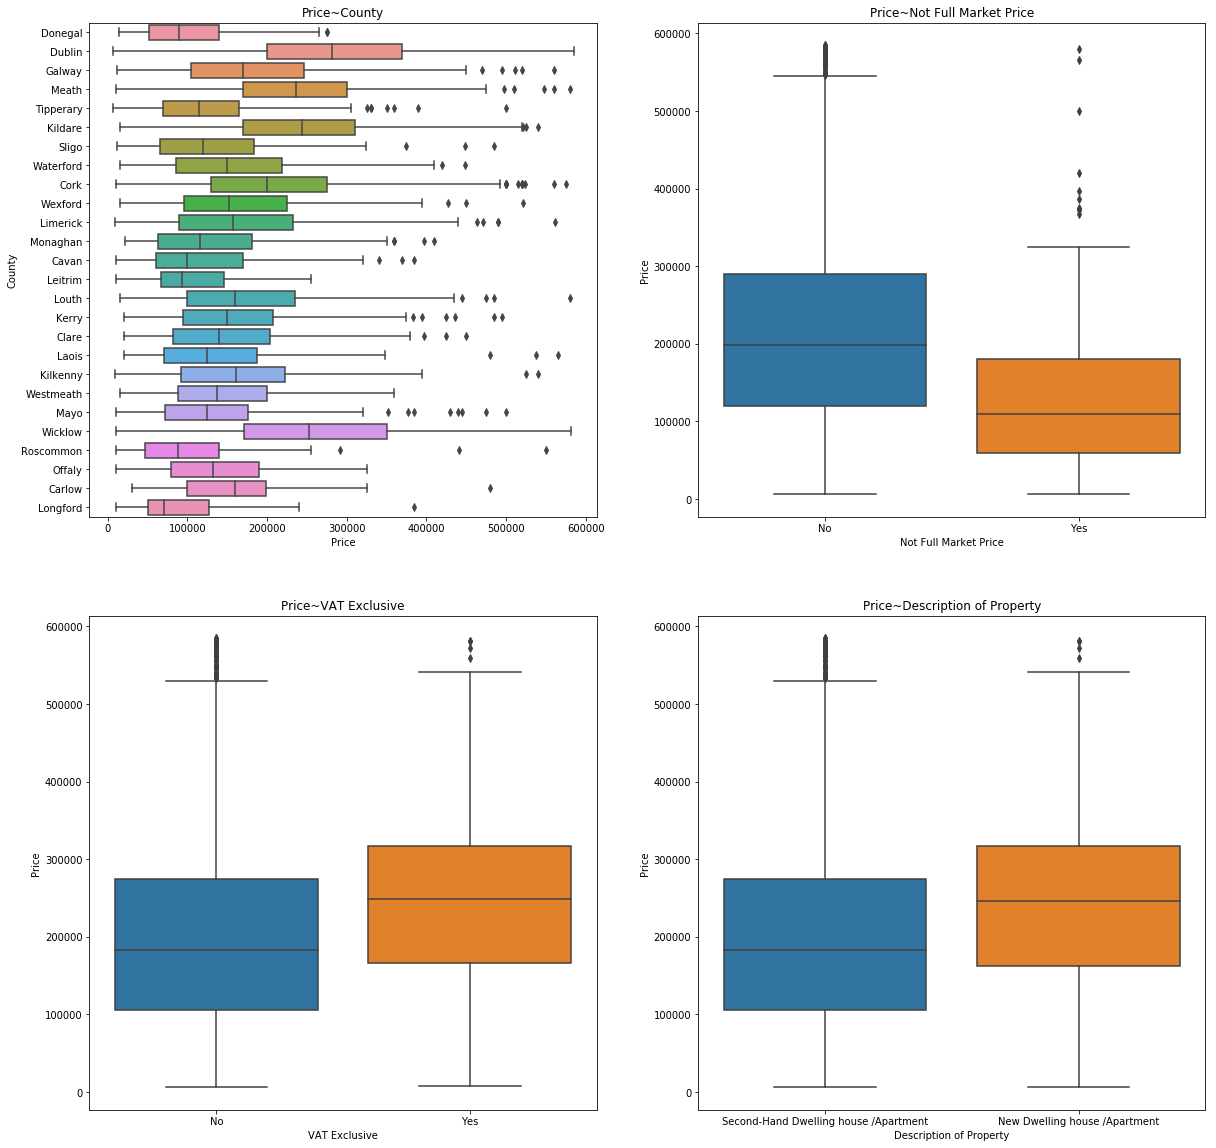

In [23]:
### pair boxplot of categorical feature and target feature
### County, Not Full Market Price,  VAT Exclusive,  Description of Property 

plt.figure(figsize=(20, 20))
plt.subplot(2, 2, 1)
sns.boxplot(y="County", x="Price", data=df1, orient="h") 
plt.title("Price~County")
plt.subplot(2, 2, 2)
sns.boxplot(x="Not Full Market Price", y="Price", data=df1)
plt.title("Price~Not Full Market Price")
plt.subplot(2, 2, 3)
sns.boxplot(x="VAT Exclusive", y="Price", data=df1)
plt.title("Price~VAT Exclusive")
plt.subplot(2, 2, 4)
sns.boxplot(x="Description of Property", y="Price", data=df1)
plt.title("Price~Description of Property")

We chose the four variables County, Not Full Market Price, VAT Exclusive, Description of Property as the category features and made a box plot of the relationship between these four features and the target variable price.  
The first graph shows price~County, from which it can be seen that there are many different types of county and the box distribution of price under different counties is almost completely different, the median price under each county is almost different, as well as the 25% quantile and 75% quantile. It is because the distribution of price under each county is different that we chose county as the new feature for predicting price.  
The second graph shows price~Not Full Market Price, from which we can see that there are only two types of Not Full Market Price, yes and no, where the median of no is higher than that of yes, and the distance between the 25% quantile and the 75% quantile of no is also greater than that of yes. We can see that the box distributions of no and yes are also different, so we can choose Not Full Market Price as the feature for predicting price.  
The third graph shows price~VAT Exclusive. From the graph, we can see that there are only two types of VAT Exclusive, yes and no, and the box distribution of yes is higher than that of no. Therefore, we can choose VAT Exclusive as the new feature for predicting price.  
The fourth graph shows price~Description of Property, from the graph we can see that Description of Property only has New Dwelling house /Apartment and Second-Hand Dwelling house /Apartment, and New The box distribution of New Dwelling house /Apartment is higher than that of Second-Hand Dwelling house /Apartment, so we choose Description of Property as a feature to predict price.  

## 2. Linear Regression

### 2.1

In [24]:
## Format data to train model

df1 = df1.drop(labels=["Date of Sale", "quarter"], axis=1) # remove data
df1["Not Full Market Price"] = df1["Not Full Market Price"].replace({"No": 0, "Yes": 1}) # binary feature, using 0 and 1 represent
df1["VAT Exclusive"] = df1["VAT Exclusive"].replace({"No": 0, "Yes": 1}) # binary feature, using 0 and 1 represent
# binary feature, using 0 and 1 represent
df1["Description of Property"] = df1["Description of Property"].replace({"New Dwelling house /Apartment": 0, 
																		 "Second-Hand Dwelling house /Apartment": 1})

df1 = pd.get_dummies(df1, columns=["County"]) # use ont-hot encodeing
df1.head()

,Price,Not Full Market Price,VAT Exclusive,Description of Property,month,weekday,County_Carlow,County_Cavan,County_Clare,County_Cork,...,County_Meath,County_Monaghan,County_Offaly,County_Roscommon,County_Sligo,County_Tipperary,County_Waterford,County_Westmeath,County_Wexford,County_Wicklow
3695,120000.0,0,0,1,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2163,115000.0,1,0,1,12,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7509,520555.0,0,0,1,1,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3199,60000.0,0,0,1,2,4,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
9324,165000.0,1,0,1,1,2,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [25]:
from sklearn.linear_model import LinearRegression
X = df1.drop(labels="Price", axis=1) # get train data
y = df1["Price"] # get target data
lr = LinearRegression() # define model
lr.fit(X, y) # train

LinearRegression()

### 2.2 

In [26]:
coef_dataframe = pd.DataFrame({"col": X.columns, "coef": lr.coef_}) # create a dataframe of coef 
coef_dataframe = coef_dataframe.sort_values(by='coef', ascending=False) # sort dataframe
coef_dataframe

,col,coef
1,VAT Exclusive,6.672980e+04
2,Description of Property,3.792855e+04
4,weekday,1.482788e+03
3,month,1.207129e+03
0,Not Full Market Price,-8.223483e+04
10,County_Dublin,-4.198379e+15
30,County_Wicklow,-4.198379e+15
13,County_Kildare,-4.198379e+15
21,County_Meath,-4.198379e+15
8,County_Cork,-4.198379e+15


coef_dataframe is a table of the coefficients of the linear regression model. The table is arranged in descending order of coefficients, from which we can see that the features contributing to the linear regression model are: VAT Exclusive, Description of Property, weekday, month. 
The coefficients on the subcategories of the County variable are all small, indicating that the County variable does not contribute to the weighting of the coefficients in the linear regression.  

By looking at the coefficient tables, we can finally conclude that in the linear regression the key characteristics are VAT Exclusive, Description of Property, weekday and month and the non-key characteristics are Not Full Market Price and County.


### 2.3 

In [27]:
sample_data = X[:10] # get sample data
pred_price = lr.predict(sample_data) # predict data 
price_df = pd.DataFrame({"Truth Price": y[:10], "Predicted Price": pred_price}) # create dataframe
price_df

,Truth Price,Predicted Price
3695,120000.00,95978.5
2163,115000.00,214426.0
7509,520555.00,176182.5
3199,60000.00,228875.5
9324,165000.00,42434.0
4280,351945.27,312288.0
5149,290000.00,244264.5
8582,65000.00,139506.0
7163,60000.00,81298.5
2999,253000.00,287384.0


In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
pred_train_set = lr.predict(X) # predict 
print("MAE on full train dataset:", mean_absolute_error(pred_train_set, y))
print("RMSE on full train dataset:", np.sqrt(mean_squared_error(pred_train_set, y)))

MAE on full train dataset: 81384.01388392181
RMSE on full train dataset: 103739.49109827334


Looking at the predicted values of the 10 samples, we can see that there is still a big difference between the predicted prices and the real prices. Looking at the prediction results's root mean square error is 103739 and the absolute value error is 81384 on the training set, it can be seen that the linear regression model does not predict PRICE very well, because the values of both RMSE and MAE are larger.  


### 2.4 

In [29]:
df1 = test_data.copy()
## process test data same as train data
df1["month"] = df1["Date of Sale"].dt.month
df1["weekday"] = df1["Date of Sale"].dt.weekday
df1 = df1.drop(labels=["Date of Sale"], axis=1)
df1["Not Full Market Price"] = df1["Not Full Market Price"].replace({"No": 0, "Yes": 1})
df1["VAT Exclusive"] = df1["VAT Exclusive"].replace({"No": 0, "Yes": 1})
df1["Description of Property"] = df1["Description of Property"].replace({"New Dwelling house /Apartment": 0,
																		 "Second-Hand Dwelling house /Apartment": 1})

df1 = pd.get_dummies(df1, columns=["County"])

# get X_test and y_test 
X_test = df1.drop(labels="Price", axis=1) 
y_test = df1["Price"]

pred_test_set = lr.predict(X_test) # predict 
print("MAE on full test dataset:", mean_absolute_error(pred_test_set, y_test))
print("RMSE on full test dataset:", np.sqrt(mean_squared_error(pred_test_set, y_test)))

MAE on full test dataset: 78775.69312477908
RMSE on full test dataset: 100982.36836298491


In [30]:
from sklearn.model_selection import cross_val_score

full_X = np.vstack((X, X_test)) # get all data
full_y = np.append(y, y_test) # get all y

lr = LinearRegression() # define new model
mae_scores = cross_val_score(lr, full_X, full_y, scoring="neg_mean_absolute_error", cv=5)  # define classic k-fold cross-validation
print("MAE on full dataset using k-fold cross-validation:", -np.mean(mae_scores))

rmse_scores = cross_val_score(lr, full_X, full_y, scoring="neg_mean_squared_error", cv=5)  # define classic k-fold cross-validation
print("RMSE on full dataset using k-fold cross-validation:", np.sqrt(-np.mean(rmse_scores)))

MAE on full dataset using k-fold cross-validation: 80785.56382392478
RMSE on full dataset using k-fold cross-validation: 103228.30897961612


The MAE on the test set was 78775 and the MAE on the training set was 81384,  The RMSE on the test set was 100982 and the RMSE on the training set was 103739. The MAE and RMSE on the test set was slightly smaller than the MAE and RMSE on the training set because there were fewer samples on the test set. However, they were close, indicating that linear regression did not under- or over-fit on this data set.  

The mean MAE value obtained was 80785 using a 5-fold cross-validation on all datasets, The mean RMSE value obtained was 103228 using a 5-fold cross-validation on all datasets. This approach selected 80% of the data as the training set and the remaining 20% as the test set five times each. This selection method is more stable than simply dividing the training and test sets to obtain a MAE and RMSE that is not affected by the division of the data. The mean MAE value of 80785 and the mean RMSE value of 103228 is slightly higher than the MAE and RMSE value obtained by dividing the data set, indicating that the test set obtained by dividing the data set is exactly the part with the smaller MAE and RMSE, which are smaller than the cross-validation on all datasets.

## 3.Decision Tree

### 3.1

In [31]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor()
tree.fit(X, y)

DecisionTreeRegressor()

### 3.2

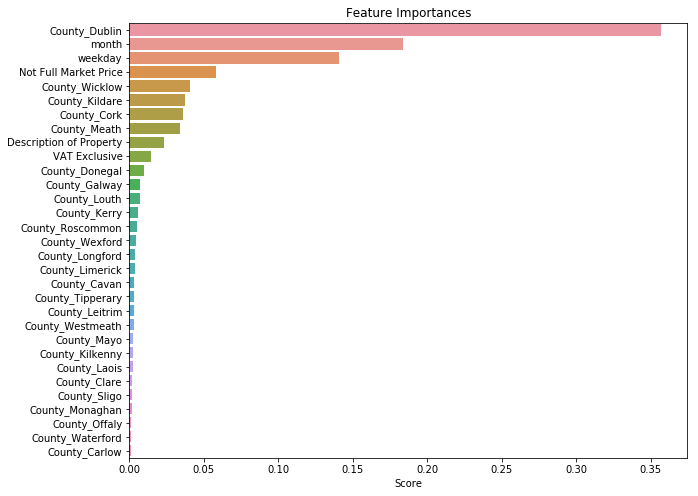

In [32]:
feat_importance = tree.feature_importances_  ## get tree's feature importance
feat_importance = pd.DataFrame(feat_importance, columns=['Score'],
                               index=X.columns) # get importance dataframe
feat_importance = feat_importance.sort_values(by='Score', ascending=False) # sort
plt.figure(figsize=(10, 8))
plt.title('Feature Importances')
sns.barplot(x=feat_importance.Score, y=feat_importance.index) # plot
plt.show()

This model is obtained by training a decision tree on training data. The figure above shows a visualisation of the decision tree model with respect to the importance of the features, the vertical coordinate of the figure is the name of each feature and the horizontal coordinate is the degree of importance of each feature, each feature is listed in descending order of importance. From the graph, we can see that the top 5 features in order are: County_Dublin, month, weekday, Not Full Market Price, County_Wicklow. The next features are almost all other sub-features of County, indicating that these sub-features do not contribute to the model.  

Therefore it can be concluded that the features that influence the decision tree are County_Dublin, month, weekday, Not Full Market Price, County_Wicklow.

### 3.3 

In [33]:
sample_data = X[:10] # get sample data
pred_price = tree.predict(sample_data) # predict data 
price_df = pd.DataFrame({"Truth Price": y[:10], "Predicted Price": pred_price}) # create dataframe
price_df

,Truth Price,Predicted Price
3695,120000.00,120000.000000
2163,115000.00,175026.000000
7509,520555.00,205711.000000
3199,60000.00,140500.000000
9324,165000.00,165000.000000
4280,351945.27,245775.790000
5149,290000.00,204285.714286
8582,65000.00,65000.000000
7163,60000.00,60000.000000
2999,253000.00,304886.363636


In [34]:
pred_train_set = tree.predict(X) # predict 
print("MAE on full train dataset:", mean_absolute_error(pred_train_set, y))
print("RMSE on full train dataset:", np.sqrt(mean_squared_error(pred_train_set, y)))

MAE on full train dataset: 63491.22812874405
RMSE on full train dataset: 88825.2643878803


Looking at the results of the 10 sample values predicted by the decision tree, which are closer to the true values, and comparing the results predicted by linear regression, it can be judged that the results predicted by the decision tree are more accurate.  

The MAE between the predicted and true values was 63491, which was less than the MAE of linear regression which was 81 384, The RMSE between the predicted and true values was 88825, which was less than the RMSE of linear regression which was 103739 and this shows that the prediction on the training set was better than linear regression.

### 3.4 

In [35]:
pred_test_set = tree.predict(X_test) # predict 
print("MAE on full test dataset:", mean_absolute_error(pred_test_set, y_test))
print("RMSE on full test dataset:", np.sqrt(mean_squared_error(pred_test_set, y_test)))

MAE on full test dataset: 90204.35969323211
RMSE on full test dataset: 116047.9711347309


In [36]:
tree = DecisionTreeRegressor() # define new model
mae_scores = cross_val_score(tree, full_X, full_y, scoring="neg_mean_absolute_error", cv=5)  # define classic k-fold cross-validation
print("MAE on full dataset using k-fold cross-validation:", -np.mean(mae_scores))

rmse_scores = cross_val_score(tree, full_X, full_y, scoring="neg_mean_squared_error", cv=5)  # define classic k-fold cross-validation
print("RMSE on full dataset using k-fold cross-validation:", np.sqrt(-np.mean(rmse_scores)))

MAE on full dataset using k-fold cross-validation: 91085.96988458416
RMSE on full dataset using k-fold cross-validation: 117138.91715522153


The MAE value of the decision tree on the test set was 90204, which was higher than the MAE value of linear regression at 78775. The RMSE value of the decision tree on the test set was 116047, which was higher than the RMSE value of linear regression at 100982, but the MAE value  and RMSE value of the decision tree on the training set was lower than that of linear regression, indicating that the decision tree was overfitting on this regression problem, resulting in less accurate predictions of the model on the test set.  

The MAE of the decision tree on the whole dataset using cross-validation is 91085 which is higher than the MAE value of 80785 for the cross-validation of the linear regression. The RMSE of the decision tree on the whole dataset using cross-validation is 117138 which is higher than the RMSE value of 103228 for the cross-validation of the linear regression, indicating that the linear regression performed better, because the cross-validation'result is more stable.

##  4.  Random Forest

### 4.1

In [37]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X, y)

RandomForestRegressor()

### 4.2

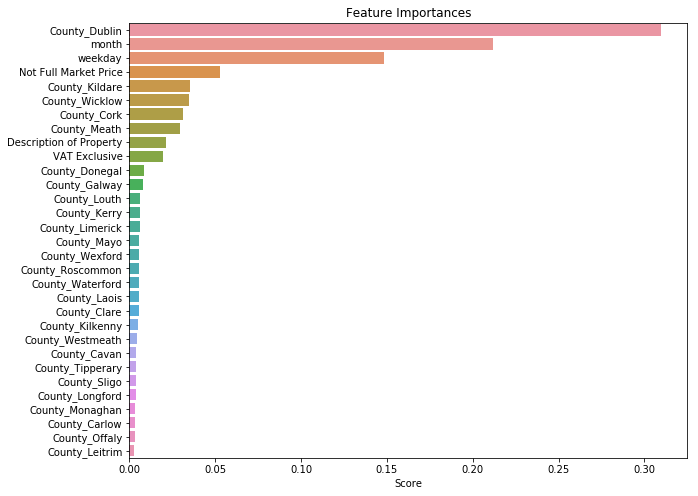

In [38]:
feat_importance = rf.feature_importances_  ## get random forest's feature importance
feat_importance = pd.DataFrame(feat_importance, columns=['Score'],
                               index=X.columns) # get importance dataframe
feat_importance = feat_importance.sort_values(by='Score', ascending=False) # sort
plt.figure(figsize=(10, 8))
plt.title('Feature Importances')
sns.barplot(x=feat_importance.Score, y=feat_importance.index) # plot
plt.show()

This model is obtained by training a random forest on training data. The figure above shows a visualisation of the random forest model with respect to the importance of the features, the vertical coordinate of the figure is the name of each feature and the horizontal coordinate is the degree of importance of each feature, each feature is listed in descending order of importance. From the graph, we can see that the top 5 features in order are: County_Dublin, month, weekday, Not Full Market Price, County_Wicklow. The next features are almost all other sub-features of County, indicating that these sub-features do not contribute to the model.  

Therefore it can be concluded that the features that influence the random forest are County_Dublin, month, weekday, Not Full Market Price, County_Wicklow.

### 4.3

In [39]:
sample_data = X[:10] # get sample data
pred_price = rf.predict(sample_data) # predict data 
price_df = pd.DataFrame({"Truth Price": y[:10], "Predicted Price": pred_price}) # create dataframe
price_df

,Truth Price,Predicted Price
3695,120000.00,105181.310233
2163,115000.00,178112.345621
7509,520555.00,203195.773200
3199,60000.00,133294.289683
9324,165000.00,150564.500000
4280,351945.27,244789.637610
5149,290000.00,207481.024892
8582,65000.00,93533.690476
7163,60000.00,82843.042800
2999,253000.00,309476.192291


In [42]:
pred_train_set = rf.predict(X) # predict 
print("MAE on full train dataset:", mean_absolute_error(pred_train_set, y))
print("RMSE on full train dataset:", np.sqrt(mean_squared_error(pred_train_set, y)))

MAE on full train dataset: 67611.75054463657
RMSE on full train dataset: 90100.89241199565


Looking at the results of the 10 sample values predicted by the random forest, which are closer to the true values, and comparing the results predicted by linear regression, it can be judged that the results predicted by the random forest are more accurate on train set.  

The MAE between the predicted and true values was 67611, which was less than the MAE of linear regression which was 81 384, The RMSE between the predicted and true values was 90100, which was less than the RMSE of linear regression which was 103739 and this shows that the prediction on the training set was better than linear regression.

### 4.4

In [43]:
pred_test_set = rf.predict(X_test) # predict 
print("MAE on full test dataset:", mean_absolute_error(pred_test_set, y_test))
print("RMSE on full test dataset:", np.sqrt(mean_squared_error(pred_test_set, y_test)))

MAE on full test dataset: 85544.29788188198
RMSE on full test dataset: 109850.14154156287


In [44]:
rf = RandomForestRegressor() # define new model
mae_scores = cross_val_score(rf, full_X, full_y, scoring="neg_mean_absolute_error", cv=5)  # define classic k-fold cross-validation
print("MAE on full dataset using k-fold cross-validation:", -np.mean(mae_scores))

rmse_scores = cross_val_score(tree, full_X, full_y, scoring="neg_mean_squared_error", cv=5)  # define classic k-fold cross-validation
print("RMSE on full dataset using k-fold cross-validation:", np.sqrt(-np.mean(rmse_scores)))

MAE on full dataset using k-fold cross-validation: 86930.85377308779
RMSE on full dataset using k-fold cross-validation: 117167.67783420737


The MAE value of the random forest on the test set was 85544, which was higher than the MAE value of linear regression at 78775. The RMSE value of the decision tree on the test set was 109850, which was higher than the RMSE value of linear regression at 100982, but the MAE value  and RMSE value of the random forest on the training set was lower than that of linear regression, indicating that the random forest was overfitting on this regression problem, resulting in less accurate predictions of the model on the test set.  

The MAE of the random forest on the whole dataset using cross-validation is 86930 which is higher than the MAE value of 80785 for the cross-validation of the linear regression. The RMSE of the random forest on the whole dataset using cross-validation is 117167 which is higher than the RMSE value of 103228 for the cross-validation of the linear regression, indicating that the linear regression performed better, because the cross-validation'result is more stable.



## 5.Improving Predictive Models.

### 5.1

| Model | train set MAE | test set MAE | cross validation MAE | train set RMSE | test set RMSE | cross validation RMSE |
|---------------|----------|-----------|-------|
|     linear regression     |   81384   |   78775       | 80785| 103739 | 100982| 103228 |
|    decision tree     |    63491  |      90002    | 91060| 88825|  116047 | 117138|
|     random forest      |  67640   |   85766      |  86884 |90100 | 109850 | 117167 | 

Comparing the RMSE values and  MAE values of each model in the above table on different datasets, it can be seen that decision trees and random forests perform better on the training set, but worse on the test set. In contrast, linear regression outperforms both decision trees and random forests in both the test set and cross-validation, so linear regression is the best model, because the goodness of the model's results in the test set and cross-validation are more representative of the model's ability to predict unknown data. So we are more interested in how the model performs on the test set.

### 5.2

The difficulty with this regression problem is that there are too few continuous variables associated with price, as well as too few features for the entire dataset, and although we extracted two continuous variables from Date of sale, they do not seem to help the model much. We tried three different types of models, namely linear regression, decision tree and random forest, to calculate MAE and RMSE values in the training set, test set and cross-validation respectively, and compared the MAE and RMSE on the training and test sets, respectively, as well as using cross-validation to get the best model of linear regression.

The above analysis allows us to obtain that the best model is the linear regression model. Firstly we have compared the models in depth and on this basis if we need to improve the accuracy of the models further we need to start with the features of the data. For example, in the above analysis we have used two features extracted from timestamps such as month and weekday, to which we can add two new features year and quater to see the results of MAE, RMSE on the training set, test set and cross-validation respectively.

In [46]:
df1 = train_data.copy() # get a copy of original df
df1["year"] = df1["Date of Sale"].dt.year # get year feature from Date -of sale
df1["month"] = df1["Date of Sale"].dt.month # get month feature from Date of sale
df1["quarter"] = df1["Date of Sale"].dt.quarter # get quarter feature from Date of sale
df1["weekday"] = df1["Date of Sale"].dt.weekday # get weekday feature form Date of sale
df1 = df1.drop(labels=["Date of Sale"], axis=1) # remove data
df1["Not Full Market Price"] = df1["Not Full Market Price"].replace({"No": 0, "Yes": 1}) # binary feature, using 0 and 1 represent
df1["VAT Exclusive"] = df1["VAT Exclusive"].replace({"No": 0, "Yes": 1}) # binary feature, using 0 and 1 represent
# binary feature, using 0 and 1 represent
df1["Description of Property"] = df1["Description of Property"].replace({"New Dwelling house /Apartment": 0, 
																		 "Second-Hand Dwelling house /Apartment": 1})

df1 = pd.get_dummies(df1, columns=["County"]) # use ont-hot encodeing
#df1.head()
X = df1.drop(labels="Price", axis=1) # get train data
y = df1["Price"] # get target data

lr = LinearRegression() # define model
lr.fit(X, y) # train


pred_train_set = lr.predict(X) # predict 
print("MAE on full train dataset:", mean_absolute_error(pred_train_set, y))
print("RMSE on full train dataset:", np.sqrt(mean_squared_error(pred_train_set, y)))

df1 = test_data.copy() # get a copy of original df
df1["year"] = df1["Date of Sale"].dt.year # get year feature from Date -of sale
df1["month"] = df1["Date of Sale"].dt.month # get month feature from Date of sale
df1["quarter"] = df1["Date of Sale"].dt.quarter # get quarter feature from Date of sale
df1["weekday"] = df1["Date of Sale"].dt.weekday # get weekday feature form Date of sale
df1 = df1.drop(labels=["Date of Sale"], axis=1) # remove data
df1["Not Full Market Price"] = df1["Not Full Market Price"].replace({"No": 0, "Yes": 1}) # binary feature, using 0 and 1 represent
df1["VAT Exclusive"] = df1["VAT Exclusive"].replace({"No": 0, "Yes": 1}) # binary feature, using 0 and 1 represent
# binary feature, using 0 and 1 represent
df1["Description of Property"] = df1["Description of Property"].replace({"New Dwelling house /Apartment": 0, 
																		 "Second-Hand Dwelling house /Apartment": 1})

df1 = pd.get_dummies(df1, columns=["County"]) # use ont-hot encodeing
#df1.head()
X_test = df1.drop(labels="Price", axis=1) # get train data
y_test = df1["Price"] # get target data

pred_test_set = lr.predict(X_test) # predict 
print("MAE on full test dataset:", mean_absolute_error(pred_test_set, y_test))
print("RMSE on full test dataset:", np.sqrt(mean_squared_error(pred_test_set, y_test)))

lr = LinearRegression() # define new model
full_X = np.vstack((X, X_test)) # get all data
full_y = np.append(y, y_test) # get all y
mae_scores = cross_val_score(lr, full_X, full_y, scoring="neg_mean_absolute_error", cv=5)  # define classic k-fold cross-validation
print("MAE on full dataset using k-fold cross-validation:", -np.mean(mae_scores))

rmse_scores = cross_val_score(lr, full_X, full_y, scoring="neg_mean_squared_error", cv=5)  # define classic k-fold cross-validation
print("RMSE on full dataset using k-fold cross-validation:", np.sqrt(-np.mean(rmse_scores)))

MAE on full train dataset: 77933.51142597363
RMSE on full train dataset: 100008.17089068724
MAE on full test dataset: 76365.69578296218
RMSE on full test dataset: 98262.21890324946
MAE on full dataset using k-fold cross-validation: 77692.32930831108
RMSE on full dataset using k-fold cross-validation: 99823.04690062244


| feature | train set MAE | test set MAE | cross validation MAE | train set RMSE | test set RMSE | cross validation RMSE |
|---------------|----------|-----------|-------|
|     original  feature   |   81384   |   78775       | 80785| 103739 | 100982| 103228 |
|    add year and quater    |    77933  |      76365    | 91060| 100008|  98262 | 99823|


When I add new feature to original model with year and quarter from Date of sale. The MAE and RMSE on train set, test set and cross-validation reduced , which reflecting the difficulty of this regression problem, we need to mine as many new features as possible to help us predict PRICE.

### 5.3 

In [47]:
df1 = train_data.copy() # get a copy of original df
df1["year"] = df1["Date of Sale"].dt.year # get year feature from Date -of sale
df1["month"] = df1["Date of Sale"].dt.month # get month feature from Date of sale
df1["quarter"] = df1["Date of Sale"].dt.quarter # get quarter feature from Date of sale
df1["weekday"] = df1["Date of Sale"].dt.weekday # get weekday feature form Date of sale
df1 = df1.drop(labels=["Date of Sale"], axis=1) # remove data
df1["Not Full Market Price"] = df1["Not Full Market Price"].replace({"No": 0, "Yes": 1}) # binary feature, using 0 and 1 represent
df1["VAT Exclusive"] = df1["VAT Exclusive"].replace({"No": 0, "Yes": 1}) # binary feature, using 0 and 1 represent
# binary feature, using 0 and 1 represent
df1["Description of Property"] = df1["Description of Property"].replace({"New Dwelling house /Apartment": 0, 
																		 "Second-Hand Dwelling house /Apartment": 1})

df1 = pd.get_dummies(df1, columns=["County"]) # use ont-hot encodeing
#df1.head()
X = df1.drop(labels="Price", axis=1) # get train data
y = df1["Price"] # get target data

lr = LinearRegression() # define model
lr.fit(X, y) # train


pred_train_set = lr.predict(X) # predict 
print("MAE on full train dataset:", mean_absolute_error(pred_train_set, y))
print("RMSE on full train dataset:", np.sqrt(mean_squared_error(pred_train_set, y)))

df1 = test_data.copy() # get a copy of original df
df1["year"] = df1["Date of Sale"].dt.year # get year feature from Date -of sale
df1["month"] = df1["Date of Sale"].dt.month # get month feature from Date of sale
df1["quarter"] = df1["Date of Sale"].dt.quarter # get quarter feature from Date of sale
df1["weekday"] = df1["Date of Sale"].dt.weekday # get weekday feature form Date of sale
df1 = df1.drop(labels=["Date of Sale"], axis=1) # remove data
df1["Not Full Market Price"] = df1["Not Full Market Price"].replace({"No": 0, "Yes": 1}) # binary feature, using 0 and 1 represent
df1["VAT Exclusive"] = df1["VAT Exclusive"].replace({"No": 0, "Yes": 1}) # binary feature, using 0 and 1 represent
# binary feature, using 0 and 1 represent
df1["Description of Property"] = df1["Description of Property"].replace({"New Dwelling house /Apartment": 0, 
																		 "Second-Hand Dwelling house /Apartment": 1})

df1 = pd.get_dummies(df1, columns=["County"]) # use ont-hot encodeing
#df1.head()
X_test = df1.drop(labels="Price", axis=1) # get train data
y_test = df1["Price"] # get target data

pred_test_set = lr.predict(X_test) # predict 
print("MAE on full test dataset:", mean_absolute_error(pred_test_set, y_test))
print("RMSE on full test dataset:", np.sqrt(mean_squared_error(pred_test_set, y_test)))

MAE on full train dataset: 77933.51142597363
RMSE on full train dataset: 100008.17089068724
MAE on full test dataset: 76365.69578296218
RMSE on full test dataset: 98262.21890324946


In [48]:
df = pd.read_csv('22032022-PPR-Price-recent.csv')
df['DateofSale(dd/mm/yyyy)'] = pd.to_datetime(df['DateofSale(dd/mm/yyyy)'], dayfirst=True, format='%Y-%m-%d')
df = df.rename(columns={'DateofSale(dd/mm/yyyy)': 'Date of Sale'})
df = df.rename(columns={'Price(€)': 'Price'})

Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1
print("Old Shape: ", df.shape)
test_4 = df[((df['Price'] < Q1 - 1.5 * IQR) | (df['Price'] > Q3 + 1.5 * IQR))]
# ''' Removing the Outliers '''
df.drop(test_4.index, inplace=True)
print("New Shape: ", df.shape)

test_3 = []
for i in range(df.shape[0]):
    if df.iloc[i]['Date of Sale'] > np.datetime64('2022-01-24T00:00:00Z'):
        test_3.append(df.iloc[i])
test_3 = pd.DataFrame(test_3)
print("Old Shape: ", df.shape)
# Check for cases that are later than 24 January 2022
print("Total number of rows dropped: ", test_3.shape[0])
df = df.drop(test_3.index)
print("New Shape: ", df.shape)

df = df.drop(['Address'], axis=1)
df = df.drop(['PostalCode'], axis=1)
df = df.drop(df[df['DescriptionofProperty']=='Teach/Árasán Cónaithe Atháimhe'].index)
df = df.drop(['PropertySizeDescription'], axis=1)

df1 = df.copy() # get a copy of original df
df1["year"] = df1["Date of Sale"].dt.year  # get year feature from Date -of sale
df1["month"] = df1["Date of Sale"].dt.month # get month feature from Date of sale
df1["quarter"] = df1["Date of Sale"].dt.quarter # get quarter feature from Date of sale
df1["weekday"] = df1["Date of Sale"].dt.weekday # get weekday feature form Date of sale
df1 = df1.drop(labels=["Date of Sale"], axis=1) # remove data
df1["NotFullMarketPrice"] = df1["NotFullMarketPrice"].replace({"No": 0, "Yes": 1}) # binary feature, using 0 and 1 represent
df1["VATExclusive"] = df1["VATExclusive"].replace({"No": 0, "Yes": 1}) # binary feature, using 0 and 1 represent
# binary feature, using 0 and 1 represent
df1["DescriptionofProperty"] = df1["DescriptionofProperty"].replace({"New Dwelling house /Apartment": 0, 
																		 "Second-Hand Dwelling house /Apartment": 1})

df1 = pd.get_dummies(df1, columns=["County"]) # use ont-hot encodeing
df1.head()

Old Shape:  (7182, 9)
New Shape:  (6748, 9)
Old Shape:  (6748, 9)
Total number of rows dropped:  5584
New Shape:  (1164, 9)


,Price,NotFullMarketPrice,VATExclusive,DescriptionofProperty,year,month,quarter,weekday,County_Carlow,County_Cavan,...,County_Meath,County_Monaghan,County_Offaly,County_Roscommon,County_Sligo,County_Tipperary,County_Waterford,County_Westmeath,County_Wexford,County_Wicklow
0,154000.00,0,0,1,2022,1,1,5,0,0,...,0,0,0,0,0,0,0,0,0,0
1,370000.00,0,0,1,2022,1,1,5,0,0,...,0,0,0,0,0,0,0,0,0,0
2,409691.63,0,1,0,2022,1,1,6,0,0,...,0,0,0,0,0,0,0,0,0,0
3,100000.00,0,0,1,2022,1,1,6,0,0,...,0,0,0,0,0,0,0,0,1,0
4,225000.00,0,0,1,2022,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
X_test = df1.drop(labels="Price", axis=1) # get train data
y_test = df1["Price"] # get target data

pred_test_set = lr.predict(X_test) # predict 
print("MAE on full test dataset:", mean_absolute_error(pred_test_set, y_test))
print("RMSE on full test dataset:", np.sqrt(mean_squared_error(pred_test_set, y_test)))

MAE on full test dataset: 87789.37498281787
RMSE on full test dataset: 118502.25018396403


After the new data set was subjected to similar pre-processing operations as the original data set, the MAE value of the best model on the new data set was 87789, the RMSE value of the best model on the new data set was 118502, which is slightly higher than the MAE and RMSE on the test set of the original data, which is normal and indicates that linear regression is largely capable of making accurate predictions of PRICE.